In [1]:
import sys
sys.path.append('../code')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from sklearn.model_selection import ShuffleSplit
import pickle

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0")
#device = torch.device('cpu')

torch.backends.cudnn.benchmark = True

import contrastive_functions

In [2]:
data_dict = contrastive_functions.get_marker_decode_dataframes()
wrist_df = data_dict['wrist_df']
task_neural_df = data_dict['task_neural_df']
notask_neural_df = data_dict['notask_neural_df']
metadata = data_dict['metadata']

neuron_list = notask_neural_df['unit'].unique()

In [3]:
trial_ids = task_neural_df['trial'].unique()
num_trials_filtered = len(trial_ids)

#Generate cv_dict for regular train/test/validate split
cv_split = ShuffleSplit(n_splits=5, test_size=.25, random_state=3)
val_split = ShuffleSplit(n_splits=1, test_size=.25, random_state=3)
cv_dict = {}
for fold, (train_val_idx, test_idx) in enumerate(cv_split.split(trial_ids)):
    for t_idx, v_idx in val_split.split(train_val_idx): #No looping, just used to split train/validation sets
        cv_dict[fold] = {'train_idx':trial_ids[train_val_idx[t_idx]], 
                        'test_idx':trial_ids[test_idx], 
                        'validation_idx':trial_ids[train_val_idx[v_idx]]} 

In [4]:
neural_offset = 5 # try 50-150 ms offset
window_size = 70
label_col = 'layout'

In [5]:
func_dict = {'wiener': contrastive_functions.run_wiener}

wiener_test_dict = {'task': list(), 'notask': list()}
for neuron_id in neuron_list:
    # Filter neural_df with task info to random subset of neurons
    task_unit_mask = task_neural_df['unit'] == neuron_id
    layout_mask = task_neural_df['unit'].str.contains(pat='layout')

    task_neural_df_filtered = task_neural_df[np.logical_or.reduce([task_unit_mask, layout_mask])].reset_index(drop=True)

    # Filter neural_df without task info to random subset of neurons
    notask_unit_mask = notask_neural_df['unit'] == neuron_id
    notask_neural_df_filtered = notask_neural_df[np.logical_or.reduce([notask_unit_mask])].reset_index(drop=True)

    df_dict = {'task': {'df': task_neural_df_filtered, 'task_info': True, 'num_cat': 4}, # num_cat = number of categorical features
                'notask': {'df': notask_neural_df_filtered, 'task_info': False, 'num_cat': 0}}
    

    for func_name, func in func_dict.items():
        for df_type, pred_df in df_dict.items():
            model, res_dict = func(wrist_df, pred_df['df'], neural_offset, cv_dict, metadata, task_info=pred_df['task_info'],
                                    window_size=window_size, num_cat=pred_df['num_cat'], label_col=label_col)
                                    
            wiener_test_dict[df_type].append(res_dict['test_corr'])



wiener_test_dict['task'] = np.vstack(wiener_test_dict['task'])
wiener_test_dict['notask'] = np.vstack(wiener_test_dict['notask'])

sort_indices = np.argsort(np.mean(wiener_test_dict['notask'], axis=1))
sorted_neuron_list = neuron_list[sort_indices]

In [6]:
func_dict = {'wiener': contrastive_functions.run_wiener, 'rnn': contrastive_functions.run_rnn}

num_neuron_list = [20,30]
num_neuron_results_dict = {'sorted_neuron_list': sorted_neuron_list}
for num_neurons in num_neuron_list:

    # Filter neural_df with task info to random subset of neurons
    task_unit_mask = np.in1d(task_neural_df['unit'].values, sorted_neuron_list[:num_neurons])
    layout_mask = task_neural_df['unit'].str.contains(pat='layout')

    task_neural_df_filtered = task_neural_df[np.logical_or.reduce([task_unit_mask, layout_mask])].reset_index(drop=True)

    # Filter neural_df without task info to random subset of neurons
    notask_unit_mask = np.in1d(notask_neural_df['unit'].values, sorted_neuron_list[:num_neurons])
    notask_neural_df_filtered = notask_neural_df[np.logical_or.reduce([notask_unit_mask])].reset_index(drop=True)

    df_dict = {'task': {'df': task_neural_df_filtered, 'task_info': True, 'num_cat': 4}, # num_cat = number of categorical features
                'notask': {'df': notask_neural_df_filtered, 'task_info': False, 'num_cat': 0}}
    

    decode_results = dict()
    for func_name, func in func_dict.items():
        decode_results[func_name] = dict()
        for df_type, pred_df in df_dict.items():
            model, res_dict = func(wrist_df, pred_df['df'], neural_offset, cv_dict, metadata, task_info=pred_df['task_info'],
                                    window_size=window_size, num_cat=pred_df['num_cat'], label_col=label_col)

            decode_results[func_name][df_type] = res_dict

            # Save results on every loop in case early stop
            num_neuron_results_dict[f'num_neuron_{num_neurons}'] = decode_results

**..****.*
Epoch: 10/1000 ... Train Loss: 2.2822  ... Validation Loss: 2.2424
**********
Epoch: 20/1000 ... Train Loss: 2.1720  ... Validation Loss: 2.1283
**********
Epoch: 30/1000 ... Train Loss: 2.0500  ... Validation Loss: 1.9979
**********
Epoch: 40/1000 ... Train Loss: 1.8646  ... Validation Loss: 1.8478
**********
Epoch: 50/1000 ... Train Loss: 1.6688  ... Validation Loss: 1.7054
**********
Epoch: 60/1000 ... Train Loss: 1.5497  ... Validation Loss: 1.6268
*.*****.**
Epoch: 70/1000 ... Train Loss: 1.4794  ... Validation Loss: 1.5537
**..***.*.
Epoch: 80/1000 ... Train Loss: 1.4280  ... Validation Loss: 1.5145
**.**.****
Epoch: 90/1000 ... Train Loss: 1.3924  ... Validation Loss: 1.4718
*******.*.
Epoch: 100/1000 ... Train Loss: 1.3673  ... Validation Loss: 1.4449
.*..**..**
Epoch: 110/1000 ... Train Loss: 1.3453  ... Validation Loss: 1.4223
*.**.*.**.
Epoch: 120/1000 ... Train Loss: 1.3276  ... Validation Loss: 1.4045
.**.....*.
Epoch: 130/1000 ... Train Loss: 1.3105  ... Valida

In [10]:
task_test_corr = list()
notask_test_corr = list()
for num_neurons in num_neuron_list:
    res_dict = num_neuron_results_dict[f'num_neuron_{num_neurons}']
    task_test_corr.append(np.stack(res_dict['rnn']['task']['test_corr']))
    notask_test_corr.append(np.stack(res_dict['rnn']['notask']['test_corr']))

task_test_corr = np.stack(task_test_corr)
notask_test_corr = np.stack(notask_test_corr)

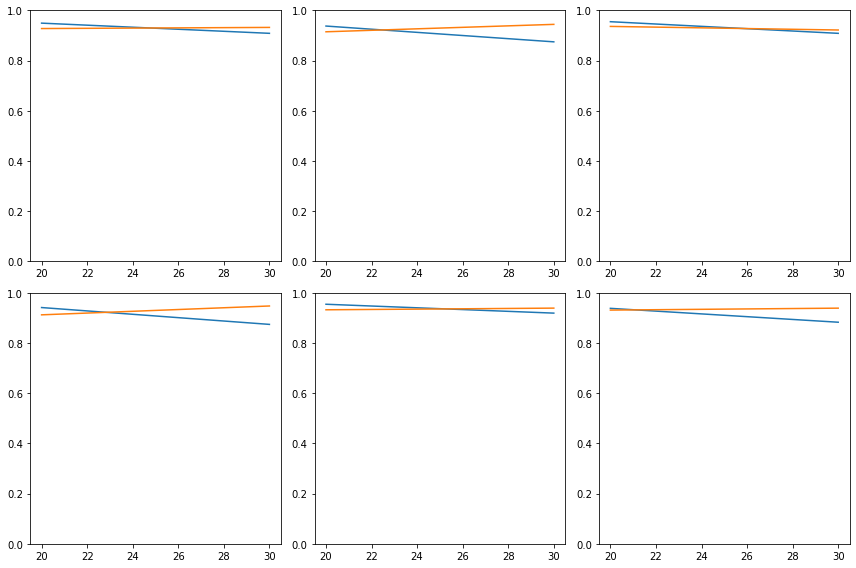

In [11]:
plt.figure(figsize=(12, 8))
for plot_idx in range(6):
    plt.subplot(2,3,plot_idx+1)
    plt.plot(num_neuron_list, notask_test_corr[:, plot_idx])
    plt.plot(num_neuron_list, task_test_corr[:, plot_idx])

    plt.ylim(0, 1)


plt.tight_layout()

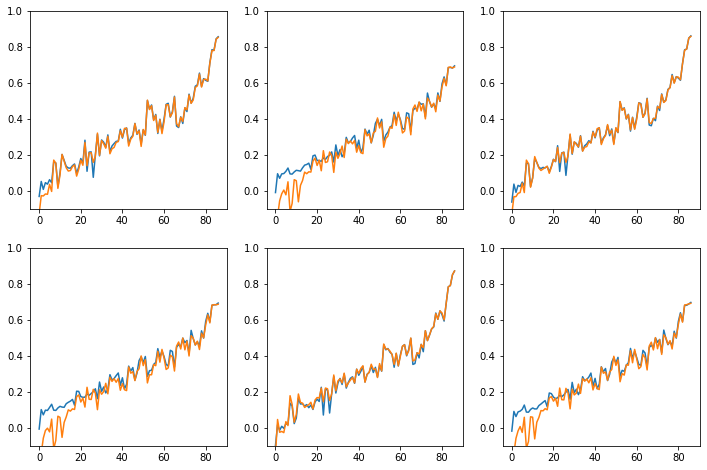

In [32]:
notask_corr_sort = wiener_test_dict['notask'][sort_indices, :]
task_corr_sort = wiener_test_dict['task'][sort_indices, :]

bins = np.linspace(-0.1,1,15)
plt.figure(figsize=(12, 8))
for plot_idx in range(6):
    plt.subplot(2,3,plot_idx+1)
    plt.plot(task_corr_sort[:, plot_idx])
    plt.plot(notask_corr_sort[:, plot_idx])

    plt.ylim(-0.1, 1)